# Analyse NLP des overviews 

Dans cette section, nous allons essayer de construire un système de recommendation des films similaires en utilisant les descriptions des films (la colonne "overviews" qui n'a pas été utilisée pour le recommendateur de la section précédente). Nous allons procéder en 4 étapes : 1). télécharger et netoyer les données en ne gardant que les colonnes qui nous intéressent (nous allons inclure dans notre analyse : overview, genres, réalisateur) 2). Préprocessing NLP afin de nettoyer les données textuelles avec SpaCy 3). Visualisation : nous allons essentiellement se servir des wordclouds pour voir les mots les plus fréquents par genre et par réalisateur 4). Enfin, nous allons modéliser avec plusieurs approches. 

## 1). Load and clean the data

In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install wordcloud
!pip install pandas pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.7 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import requests

from wordcloud import WordCloud
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Load data 
file_path = "/home/onyxia/work/projet_python_films/Data processing/data_IMDB_TMDB_join.parquet"
df = pd.read_parquet(file_path)

In [4]:
# Nettoyage du df 
def clean_df(df):
    cols_to_keep = ['originalTitle', 'genres', 'overview', 'director_name', 'popularity_TMDB']
    df_cleaned = df[cols_to_keep].copy()
    df_cleaned = df_cleaned.rename(columns={'originalTitle': 'title'})
    df_cleaned = df_cleaned.rename(columns={'director_name': 'director'})
    df_cleaned['genres'] = df_cleaned['genres'].fillna('').apply(lambda x: x.split(',') if x != '' else [])
    df_cleaned = df_cleaned.dropna(subset=['overview'])
    
    return df_cleaned


df_overviews = clean_df(df)
df_overviews.head()

,title,genres,overview,director,popularity_TMDB
0,Miss Jerry,[Romance],The adventures of a female reporter in the 1890s.,Alexander Black,0.2544
1,The Corbett-Fitzsimmons Fight,"[Documentary, News, Sport]","This legendary fight was filmed on March 17, 1...",Enoch J. Rector,0.0511
2,The Story of the Kelly Gang,"[Action, Adventure, Biography]",Just as Galeen and Wegener's Der Golem (1915) ...,Charles Tait,0.1518
3,L'enfant prodigue,[Drama],The first feature-length motion picture produc...,Michel Carré,0.0632
4,The Life of Moses,"[Biography, Drama, Family]",Released in five parts (The Persecution of the...,J. Stuart Blackton,0.9570


## 2). Pré-processing NLP

In [5]:
# Minuscules, lemmatisation, retrait stop-words/ponctuation
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def preprocess_nlp(text):
    # Traitement par spacy : mise en minuscule et lemmatisation
    doc = nlp(text.lower())
    # On retire la ponctuation et les stop-words
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

Nous allons télécharger directement le fichier parquet contenant `overview_clean` qui a été déposé sur le drive, car la transformation avec `SpaCy` prend autour de 20 minutes. Vous pouvez néanmoins voir le code qui a été implémenté pour obtenir la colonne `overview_clean` ci-dessous. 

In [9]:
DRIVE_FILE_ID = '1oKmLRugZHeyfe1Idh_j7agBBRczoKbn_'
LOCAL_FILE = 'movies_nlp_ready.parquet'

In [10]:
def load_data(drive_id, local_path, fallback_func, dataframe_to_process=None):
    """
    Tente de télécharger le fichier pré-traité (local, ensuite drive). Si les deux options échouent, lance le preprocessing NLP manuellement.
    """
    if os.path.exists(local_path):
        print(f"Fichier local '{local_path}' trouvé. Chargement...")
        return pd.read_parquet(local_path)

    print(f"Tentative de téléchargement depuis Google Drive (ID: {drive_id})...")
    try:
        url = "https://docs.google.com/uc?export=download"
        session = requests.Session()
        response = session.get(url, params={'id': drive_id}, stream=True)
        
        token = None
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                token = value
                break
        if token:
            response = session.get(url, params={'id': drive_id, 'confirm': token}, stream=True)

        with open(local_path, "wb") as f:
            for chunk in response.iter_content(32768):
                if chunk: f.write(chunk)
        
        print("Téléchargement réussi !")
        return pd.read_parquet(local_path)

    except Exception as e:
        print(f"Échec du téléchargement ({e}).")
        if dataframe_to_process is not None:
            print("Lancement du preprocessing NLP manuel (Prévoyez ~20 min)...")
            dataframe_to_process['overview_clean'] = dataframe_to_process['overview'].apply(fallback_func)
            # Sauvegarder localement pour la prochaine fois
            dataframe_to_process.to_parquet(local_path)
            return dataframe_to_process
        else:
            raise Exception("Erreur : Aucun DataFrame fourni pour le fallback.")

In [14]:
df_overviews = load_data(DRIVE_FILE_ID, LOCAL_FILE, preprocess_nlp)
df_overviews.head()

Fichier local 'movies_nlp_ready.parquet' trouvé. Chargement...


,title,genres,overview,director,overview_clean
0,Miss Jerry,[Romance],The adventures of a female reporter in the 1890s.,Alexander Black,adventure female reporter 1890s
1,The Corbett-Fitzsimmons Fight,"[Documentary, News, Sport]","This legendary fight was filmed on March 17, 1...",Enoch J. Rector,legendary fight film march 17 1897 63 mm film ...
2,The Story of the Kelly Gang,"[Action, Adventure, Biography]",Just as Galeen and Wegener's Der Golem (1915) ...,Charles Tait,galeen wegener der golem 1915 see testament ...
3,L'enfant prodigue,[Drama],The first feature-length motion picture produc...,Michel Carré,feature length motion picture produce europe r...
4,The Life of Moses,"[Biography, Drama, Family]",Released in five parts (The Persecution of the...,J. Stuart Blackton,release part persecution child israel egyptian...


## 3). Visualiser les données

In [15]:
# Creating Wordclouds 

def plot_wordcloud(text, title, color_map="YlOrRd"):
    """Génère un nuage de mots avec un style cinéma"""
    # Pour un style "cinéma", on utilise un fond noir et des couleurs chaudes
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='black',
        colormap=color_map,
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20, color='white', backgroundcolor='black')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


def show_director_cloud(df, director_name):
    """Affiche le nuage de mots pour un réalisateur spécifique"""
    director_movies = df[df['director'] == director_name]
    if director_movies.empty:
        print(f"Réalisateur '{director_name}' non trouvé.")
        return
    
    text = " ".join(director_movies['overview_clean'])
    plot_wordcloud(text, f"Univers Visuel : {director_name}", "Blues")

def show_genre_cloud(df, genre_name):
    """Affiche le nuage de mots pour un genre spécifique"""
    # On filtre les films qui contiennent le genre dans leur liste
    genre_movies = df[df['genres'].apply(lambda x: genre_name in x)]
    text = " ".join(genre_movies['overview_clean'])
    plot_wordcloud(text, f"Thématiques du genre : {genre_name}", "magma")

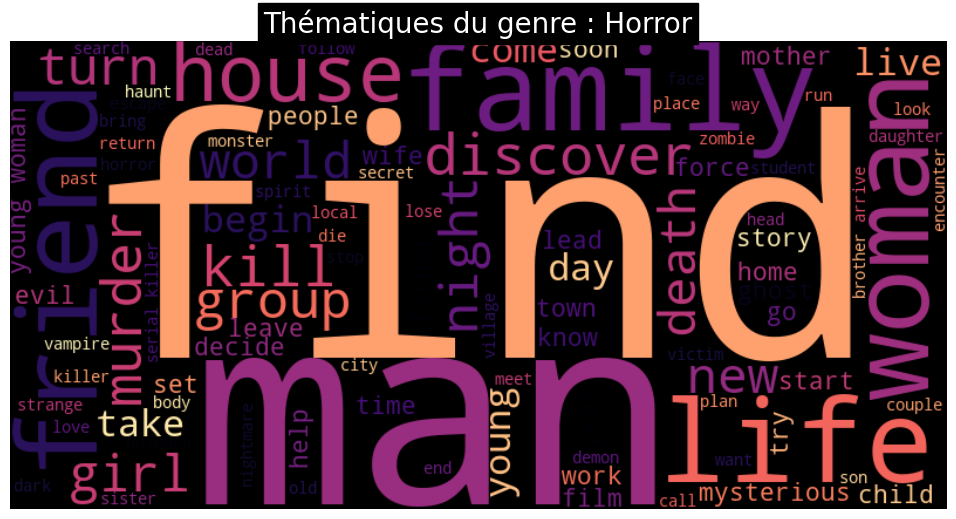

In [16]:
show_genre_cloud(df_overviews, "Horror")

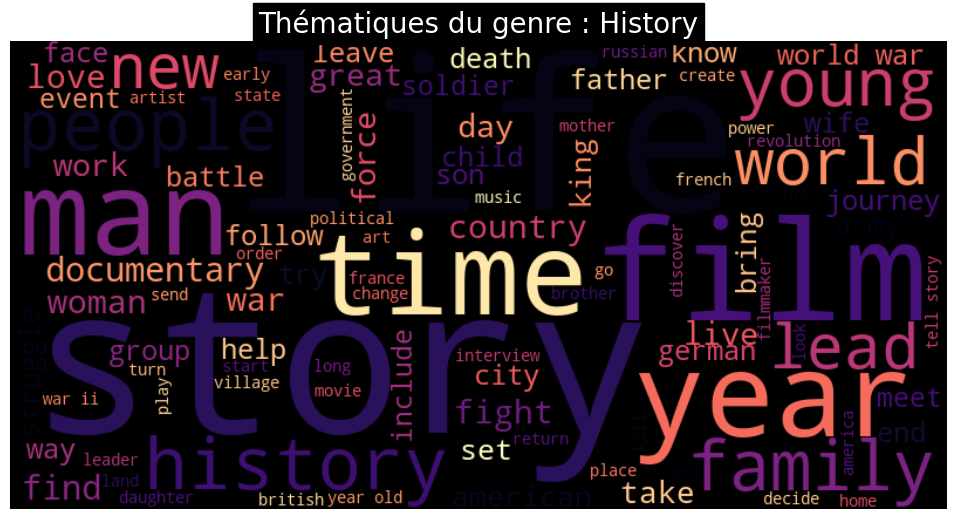

In [23]:
show_genre_cloud(df_overviews, "History")

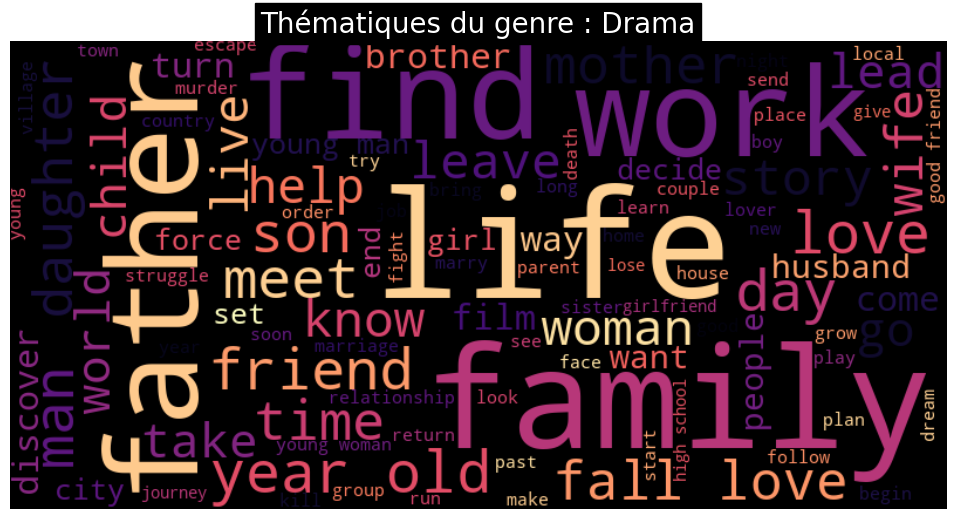

In [24]:
show_genre_cloud(df_overviews, "Drama")

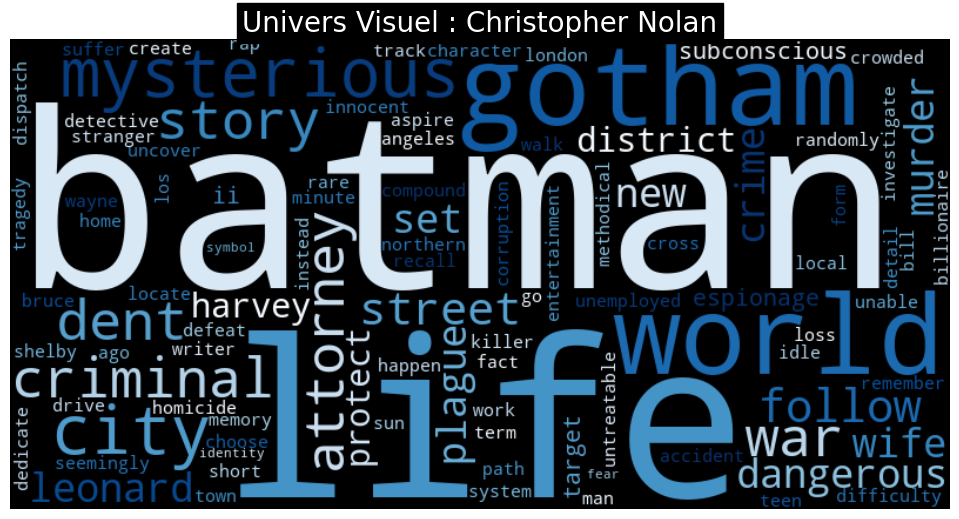

In [17]:
show_director_cloud(df_overviews, "Christopher Nolan")

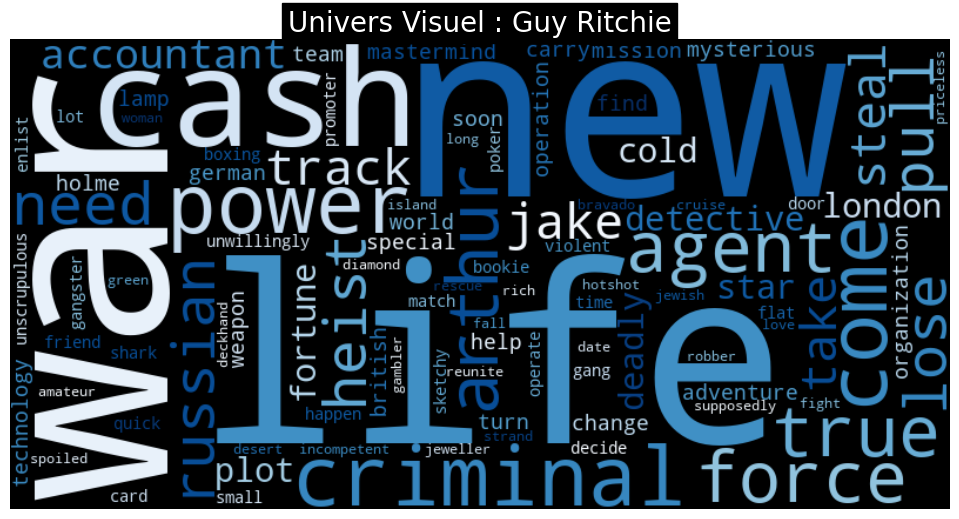

In [19]:
show_director_cloud(df_overviews, "Guy Ritchie")

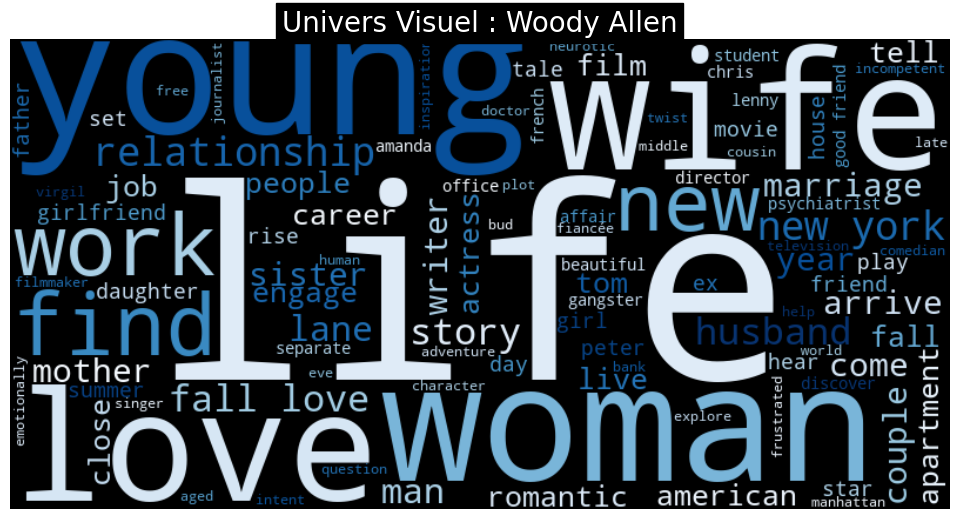

In [21]:
show_director_cloud(df_overviews, "Woody Allen")

## 5). Modélisation 1 : Cosine Similarity

Dans cette section, nous allons directement implementer la méthode basée sur Sentence transformers, car l'approche de bag of words n'a pas donné des bons résultats. En effet, les recommendations étaient basées sur la recherche exacte des mêmes mots sans s'intéresser à leur signification sémantique.  

In [30]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 87.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 37.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 73.5 MB/s  0:00:09m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 67.8 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.8 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 102.1 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 3.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 89.1 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 101.7 MB/s  0:00:010:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 97.9 MB/s  0:00:00
   ━━━━━

In [31]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


De la même manière, ici, nous allons télécharger un fichier parquet déjà enregistré sur google drive, afin d'éviter un temps d'attente (presque 1h). 

In [35]:
df_overviews['genres_str'] = df_overviews['genres'].apply(lambda x: ' '.join(x))

# On crée la soupe en combinant tout (on gère les NaN au passage)
# On peut aussi répéter le réalisateur ou les genres pour leur donner plus de poids
df_overviews['soup'] = (
    df_overviews['genres_str'] + ' ' + 
    df_overviews['director'].fillna('') + ' ' + 
    df_overviews['overview_clean'].fillna('')
)

# 1. Chargement d'un modèle pré-entraîné (plus performant que Word2Vec pour les phrases)
# Ce modèle transforme chaque "soup" en un vecteur dense de 384 dimensions
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Création des embeddings
print("Calcul des vecteurs sémantiques (Embeddings)...")
embeddings = model.encode(df_overviews['soup'].tolist(), show_progress_bar=True)

Calcul des vecteurs sémantiques (Embeddings)...


Batches: 100%|██████████| 7457/7457 [23:43<00:00,  5.24it/s] 


In [57]:
# 3. Fonction de recommandation par similarité cosinus
def get_semantic_recommendations(title, df, embeddings, n=5):
    if title not in df['title'].values:
        return "Film non trouvé."
    
    # Trouver l'index du film
    idx = df[df['title'] == title].index[0]
    
    # Calcul de la similarité cosinus entre le vecteur du film et tous les autres
    # Contrairement au TF-IDF, ici on compare des vecteurs de sens (Cours 03)
    query_embedding = embeddings[idx].reshape(1, -1)
    sim_scores = cosine_similarity(query_embedding, embeddings).flatten()
    
    # Récupérer les indices des films les plus proches
    related_indices = sim_scores.argsort()[::-1][1:n+1]
    
    return df[['title', 'genres', 'director']].iloc[related_indices]

# TEST
print("Recommandations sémantiques pour 'Inception':")
print(get_semantic_recommendations("Django Unchained", df_overviews, embeddings, 10))

Recommandations sémantiques pour 'Inception':
                              title                    genres  \
125812              Fastey Fasaatey          [Drama, Romance]   
103640                        Rabun  [Drama, Family, Romance]   
73206          Fakir bir kiz sevdim          [Drama, Romance]   
85558   Aap Mujhe Achche Lagne Lage  [Action, Drama, Romance]   
251601                   Jwar Bhata  [Action, Drama, Romance]   
250549                  Tomake Chai  [Action, Drama, Romance]   
115280       Fakir Asiklarin Romani          [Drama, Romance]   
108347             Murad'in Türküsü  [Comedy, Drama, Romance]   
85568                         Arpan          [Drama, Romance]   
155422                       Heiran          [Drama, Romance]   

                 director  
125812       Amit Agarwal  
103640       Yasmin Ahmad  
73206      Sirri Gültekin  
85558        Vikram Bhatt  
251601     Dulal Bhowmick  
250549        Swapan Saha  
115280     Osman F. Seden  
108347        